Gene age plot created


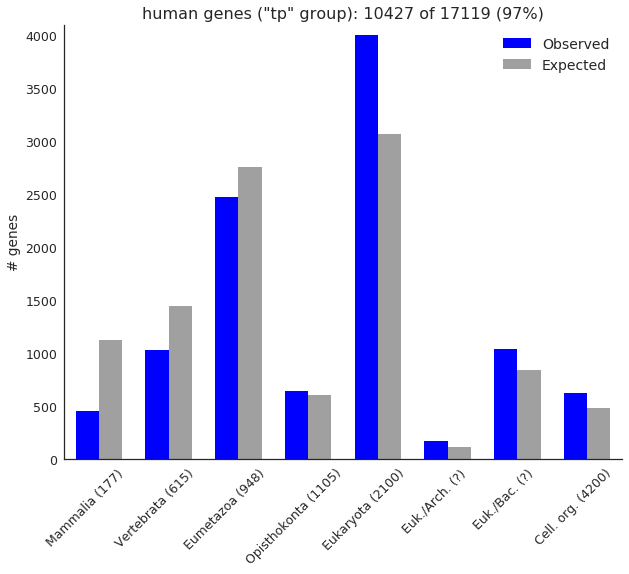

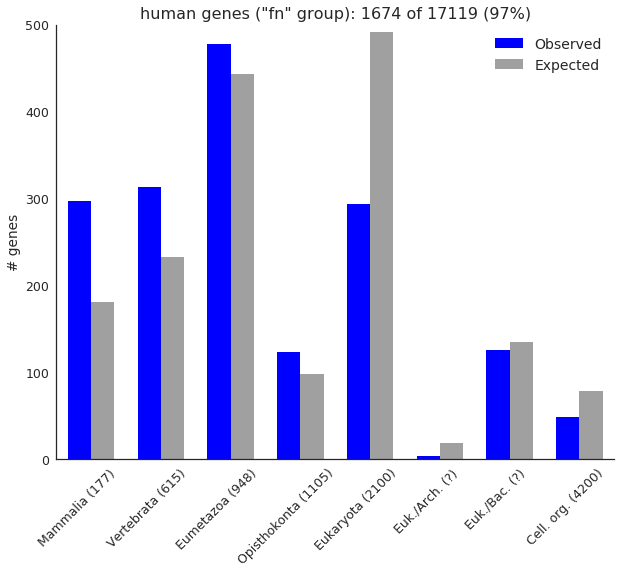

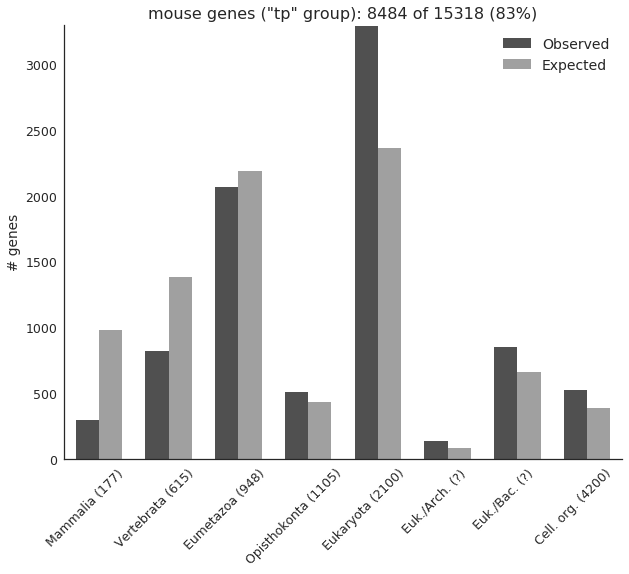

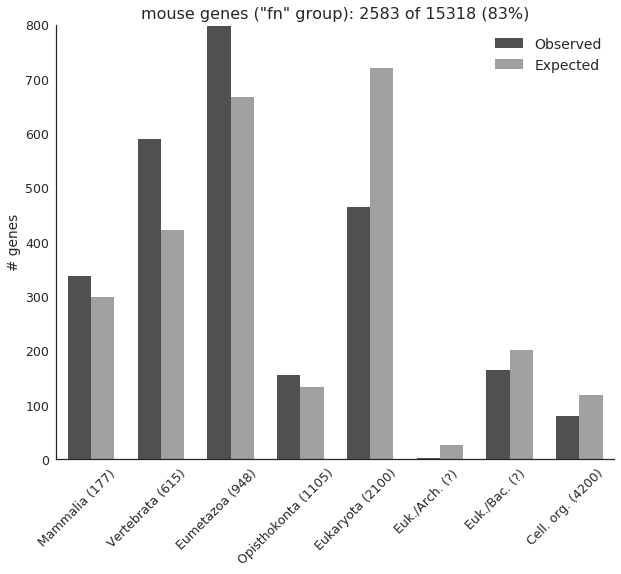

In [61]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import json as js
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import warnings as warn

import sklearn.exceptions as skle

warn.filterwarnings('error', message='Precision.+', category=skle.UndefinedMetricWarning)

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

from sklearn.metrics import accuracy_score

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
stat_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize')
stat_file = os.path.join(stat_folder, 'agg_expstat_est.h5')
ortho_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')
ortho_pred = os.path.join(ortho_folder, 'orthopred_odb_v9.h5')

cache_dir = '/home/pebert/.jupyter/cache'

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
ref_folder = '/home/pebert/work/code/mpggit/refdata/annotation'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))
lca_times_file = os.path.join(ref_folder, 'lca_dist.tsv')
species_file = os.path.join(ref_folder, 'species.tsv')

gene_age_files = {'human': '/TL/deep/fhgfs/projects/pebert/thesis/refdata/geneage/raw/main_HUMAN.csv',
                  'mouse': '/TL/deep/fhgfs/projects/pebert/thesis/refdata/geneage/raw/main_MOUSE.csv'}

id_map_files = {'human': '/TL/deep/fhgfs/projects/pebert/thesis/refdata/geneage/raw/main_human_uniprot_ensembl.txt',
                'mouse': '/TL/deep/fhgfs/projects/pebert/thesis/refdata/geneage/raw/main_mouse_uniprot_ensembl.txt'}

run_exec_gene_ages = True

show_figures = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

gene_ages = [('Eumetazoa', 948), ('Eukaryota', 2100),
             ('Vertebrata', 615), ('Opisthokonta', 1105),
             ('Mammalia', 177), ('Euk+Bac', 3500),
             ('Euk_Archaea', 3000), ('Cellular_organisms', 4200)]

age_labels = {'Eumetazoa': 948, 'Eukaryota': 2100,
              'Vertebrata': 615, 'Opisthokonta': 1105,
              'Mammalia': 177, 'Euk+Bac': '?',
              'Euk_Archaea': '?', 'Cellular_organisms': 4200}

group_labels = {'Eumetazoa': 'Eumetazoa', 'Eukaryota': 'Eukaryota',
                'Vertebrata': 'Vertebrata', 'Opisthokonta': 'Opisthokonta',
                'Mammalia': 'Mammalia', 'Euk+Bac': 'Euk./Bac.',
                'Euk_Archaea': 'Euk./Arch.', 'Cellular_organisms': 'Cell. org.'}

def exec_gene_ages():
    cache_data = os.path.join(cache_dir, 'plot_gene_cons_categ.h5')
    
    with pd.HDFStore(cache_data, 'r') as hdf:
        for species in ['human', 'mouse']:
            data = hdf['{}/body/groups'.format(species)]
            data['name'] = data.index
            spec_color = plot_colors['species'][species]['rgb']
            total_genes = data.index.unique().size
                                                
            id_map = pd.read_csv(id_map_files[species], sep='\t')
            id_map.columns = ['uniprot_id', 'name']  # from - to
            id_map = id_map.loc[id_map['name'].isin(data['name']), :].copy()

            data = data.merge(id_map, on='name', how='outer')
            
            age_annot = pd.read_csv(gene_age_files[species])
            age_annot = age_annot.loc[age_annot['uniprot_id'].isin(id_map['uniprot_id']), :].copy()
            
            data = data.merge(age_annot, on='uniprot_id', how='outer')
            data.dropna(axis=0, how='any', subset=['modeAge'], inplace=True)
            
            # count bg dist
            sub_bg = data.loc[:, ['name', 'modeAge']].copy()
            sub_bg.drop_duplicates(inplace=True)
            total_bg = sub_bg['name'].unique().size
            bg_count = col.Counter(sub_bg['modeAge'].values)
            
            num_annotated = int(np.round(total_bg / total_genes, 2) * 100)
            
            for group in ['tp', 'fn']:
                sub_grp = data.loc[data[group] == 1, :].copy()
                sub_total = sub_grp['name'].unique().size
                bg_factor = sub_grp['name'].unique().size / total_bg
                sub_counts = col.Counter(sub_grp['modeAge'].values)
                title = '{} genes ("{}" group): {} of {} ({}%)'.format(species, group, sub_total,
                                                                       total_bg, num_annotated)
                fig, exart = plot_count_bars(sub_counts, spec_color, bg_count, bg_factor, title)
                if save_figures:
                    outpath = os.path.join(out_folder, 'main', 'fig_X_main_{}_gene-age_{}.svg'.format(species, group))
                    fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                    outpath = outpath.replace('.svg', '.png')
                    fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
    return True
            
            
            
            
            
def plot_count_bars(fg_group, fg_color, bg_group, bg_factor, title):
    """
    """
    sort_order = sorted(gene_ages, key=lambda t: t[1])
    
    fg_means = np.array([fg_group[l] for l, t in sort_order], dtype=np.int32)
    bg_means = np.array([bg_group[l] for l, t in sort_order], dtype=np.float32)
    bg_means *= bg_factor
    bg_means.round(0)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(0, 6)
    
    x_limit = max(fg_means.max(), bg_means.max())
    x_limit = np.ceil(x_limit / 100) * 100
    
    ax.set_ylim(0, x_limit)
    
    
    bar_width = 0.25
    x_fg = np.arange(0.25, len(sort_order), 0.75)[:fg_means.size]
    x_bg = np.arange(0.5, len(sort_order), 0.75)[:bg_means.size]
    x_ticks = (x_fg + x_bg) / 2.
    x_ticks -= 0.15
    
    x_labels = []
    for grp, dist in sort_order:
        label = group_labels[grp]
        mya = str(age_labels[grp])
        x_labels.append('{} ({})'.format(label, mya))
    x_ticks = x_ticks[:len(x_labels)]
        
    ax.bar(x_fg[:fg_means.size], fg_means, color=fg_color, width=bar_width, label='Observed')
    ax.bar(x_bg[:bg_means.size], bg_means, color='grey', alpha=0.75, width=bar_width, label='Expected')
    
    ax.legend(fontsize=14)
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, rotation=45)
    
    ax.set_ylabel('# genes')
    ax.set_title(title, fontsize=16)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return fig, []
   
    
if run_exec_gene_ages:
    execd = exec_gene_ages()
    print('Gene age plot created')
